In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from __future__ import print_function
from layers import *
from networks import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

session = None
def get_session():
    global session
    if session is None:
        session = tf.InteractiveSession()
    return session

def initialize_params(params, sess):
    initializable_variables = filter(lambda v: hasattr(v, 'initializer'), params.values())
    if params is not None: sess.run(list(map(lambda v: v.initializer, initializable_variables)))
        

def eval_t(tensor, params=None, feed_dict={}):
    with tf.Session() as sess:
        initialize_params(params, sess)
        return sess.run(tensor, feed_dict)

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Batch normalization 2.1
In this exercise you will implement batch normalization in the function **batch_norm** in **layers.py**.

In batch normalization you find the average and standard deviation over the batch dimension, and then normalize the input.

![batch normalization](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)



You should have one average and one mean value for each input channel and each spatial position. You should also create one *gamma* and one *beta* variable with the same shape. After the normalization (subtract *mean* and divide by *standard deviation*), you should multiply with *gamma* and finally add *beta*.

*gamma* should be initialized to 1 and *beta* to zero, but they should both be trainable.

In this first part of the exercise you can just ignore the variable **is_training**, and just implement the case, where you are training your network.

In [223]:
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)

x = tf.convert_to_tensor(np.random.uniform(0, 1000, size=(2, 12, 12, 3)), dtype=tf.float32)
W = np.random.normal(size=(3, 3, 3, 2))
b = np.random.normal(size=(2,))

batch_out, params, update_ops = batch_norm(x)

output = eval_t(batch_out, params)
assert np.abs(output.mean()) < 1e-6 and np.abs(1 - output.std()) < 1e-6, \
    'Batchnorm is not normalizing properly. Expected zero mean and unit standard deviation, got: (%f, %f)'\
    % (output.mean(), output.std())
print(output.mean(), output.std())

-1.6005e-08 1.0


## Batch normalization under testing 2.2
Normally you don't want your result to be dependent on the other images in the batch. We also like to get the same result everytime we send in the same image.

Under testing with batch normalization, we usually use an accumulated **mean** and **standard deviation** for the whole training set, instead of just the incomming batch. To implement this we keep an *exponentially smoothed* average of both variables.

For this exercise we will give you most of the part, since it is quite *tensorflow* technical. If you find this hard, we recommend you to skip this part and try again after you are finished with the rest.

We initialize *average_mean* and *average_var* to zero:

``` python
  average_mean = tf.Variable(tf.zeros_like(batch_mean))
  average_var = tf.Variable(tf.zeros_like(batch_var))
```

then we create assign operators, so we can update them during training:

``` python
  assign_mean = average_mean.assign(average_mean*0.85 + batch_mean*0.15)
  assign_var = average_var.assign(average_var*0.85 + batch_var*0.15)
```

**OBS**! Remember that assign operators is not run at once, but run every time you do sess.run(assign_mean) or sess.run(assign_var)

Finally to chooses you can use **tf.cond** to choose what **mean** and **variance** you will be using based on the variable **is_training_tensor**.

``` python
  mean, var = tf.cond(is_training_tensor, lambda: (batch_mean, batch_var), lambda: (average_mean, average_var))
```

Here **tf.cond** return the batch_mean and batch_var if is_training_tensor=True and the averages otherwise.

In [222]:
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)

x = tf.convert_to_tensor(np.random.uniform(0, 1000, size=(2, 12, 12, 3)), dtype=tf.float32)
W = np.random.normal(size=(3, 3, 3, 2))
b = np.random.normal(size=(2,))

batch_out, params, update_op = batch_norm(x, is_training=False)
with tf.Session() as sess:
    initialize_params(params, sess)
    b1 = sess.run(batch_out)
    print('Standard deviation of output before update', b1.std() )

    for i in range(50):
        sess.run(update_op)

    b2 = sess.run(batch_out)
    print('Standard deviation of output after update', b2.std() )
    output = sess.run(batch_out)# eval_t(batch_out, params)
    assert np.abs(output.mean()) < 5.0  and np.abs(1 - output.std()) < 5.0, \
        'Batchnorm is not normalizing properly. Expected zero mean and unit standard deviation, got: (%f, %f)'\
        % (output.mean(), output.std())

Standard deviation of output before update 288.117
Standard deviation of output after update 1.00015


## Deep network with batch normalization 2.3
Build your network in the same way as in 1.3, but this time include your **batch_norm** function before every convolutional layer.

Update our **parameters** from your **conv2d** layer with the **batch_norm** parameters, so you also get **'conv1/gamma'**, **'conv1/beta'** etc.

With batch normalization it is important that you also run your **update_op**. At the end of **deep_network_with_batchnorm**, the update_ops are grouped, but you have to put all **update_ops** from the **batch_norm** layer into the list called **update_ops**.

Then when you train your network, you have to remembre to also run your **update_op**.

To get everything right with *batch normalization* may be tricky. I therefore recommend that you try without the "testing mode" first. You can simply feed in *is_training: True* everywhere, and you don't have to mind about updates and all the other complications.

If you do infact use *is_training: True*, when testing, i recommend using as large batch-size as possible.

If you get everything right with the batch norm, you should experience that your model get *better results*, *more robust to parameter changes* and *have a smaller difference between training and test*.

In [99]:
from cifar import load_cifar
def scale_images(imgs):
    imgs = imgs.astype(np.float32)
    imgs -= imgs.min()
    imgs /= imgs.max()
    return imgs*2 - 1

x_train, y_train = load_cifar()
x_train = scale_images(x_train)
x_test, y_test = load_cifar(test=True)
x_test = scale_images(x_test)

print('Dataset loaded with shapes:', x_train.shape, y_train.shape)
print('Dataset loaded with shapes:', x_test.shape, y_test.shape)

Dataset loaded with shapes: (50000, 32, 32, 3) (50000,)
Dataset loaded with shapes: (10000, 32, 32, 3) (10000,)


[    0/10000] TRAIN loss: 2.29 	 TRAIN accuracy: 0.19
[  100/10000] TRAIN loss: 1.54 	 TRAIN accuracy: 0.47
[  200/10000] TRAIN loss: 1.30 	 TRAIN accuracy: 0.55
[  300/10000] TRAIN loss: 1.20 	 TRAIN accuracy: 0.52
[  400/10000] TRAIN loss: 0.99 	 TRAIN accuracy: 0.73
[  500/10000] TRAIN loss: 1.44 	 TRAIN accuracy: 0.52
[  600/10000] TRAIN loss: 1.35 	 TRAIN accuracy: 0.53
[  700/10000] TRAIN loss: 0.87 	 TRAIN accuracy: 0.70
[  800/10000] TRAIN loss: 1.22 	 TRAIN accuracy: 0.53
[  900/10000] TRAIN loss: 0.91 	 TRAIN accuracy: 0.67
[ 1000/10000] TRAIN loss: 1.28 	 TRAIN accuracy: 0.55
[ 1100/10000] TRAIN loss: 0.84 	 TRAIN accuracy: 0.66
[ 1200/10000] TRAIN loss: 0.88 	 TRAIN accuracy: 0.66
[ 1300/10000] TRAIN loss: 1.13 	 TRAIN accuracy: 0.62
[ 1400/10000] TRAIN loss: 0.85 	 TRAIN accuracy: 0.78
[ 1500/10000] TRAIN loss: 0.87 	 TRAIN accuracy: 0.72
[ 1600/10000] TRAIN loss: 0.82 	 TRAIN accuracy: 0.64
[ 1700/10000] TRAIN loss: 0.71 	 TRAIN accuracy: 0.70
[ 1800/10000] TRAIN loss: 0.

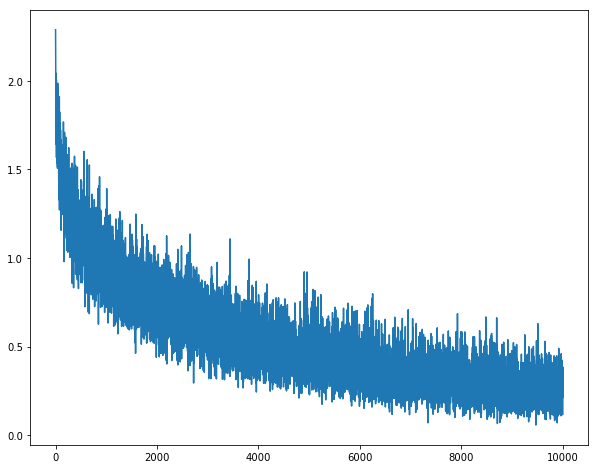

In [221]:
tf.reset_default_graph();

from matplotlib import pyplot as plt

batch_size = 64
x_in = tf.placeholder(tf.float32, [batch_size, 32, 32, 3], name='x_in')
y_in = tf.placeholder(tf.int32, [batch_size], name='y_in')
is_training = tf.placeholder(tf.bool)

number_of_classes = 10

filters = (32, 64, 128, 256) #Change filters to improve your network
strides = (2, 3, 3, 2) #Change stride to improve your network

y = tf.one_hot(y_in, number_of_classes)
logits, loss, params, update_op = deep_network_with_batchnorm(x_in, y,
                                                   number_of_classes=number_of_classes,
                                                   filters=filters,
                                                   strides=strides,
                                                   is_training=is_training)

with tf.Session() as sess:
    train_loss_history = []
    test_loss_history = []
    
    #Write your code for training and testing
    #YOUR CODE HERE
    is_training_var = tf.Variable(True, dtype=tf.bool)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    init_op = tf.global_variables_initializer()
    #init_op = tf.initialize_all_variables()
    sess.run(init_op, {is_training:is_training_var})    
    
    train_iterations = 10000
    for i in range(train_iterations):
        batch_ind = np.random.choice(len(y_train), batch_size)
        x_batch, y_batch = x_train[batch_ind], y_train[batch_ind]        
        loss_val, logit_vals, _, _ = sess.run([loss, logits, train_op, update_op], {x_in:x_batch, 
                                                                                    y_in:y_batch, 
                                                                                    is_training:True})
        train_acc = (logit_vals.argmax(1) == y_batch).mean()
        train_loss_history.append(loss_val)
        
        if i % 100 == 0:
            print('[%5d/%5d] TRAIN loss: %.2f \t TRAIN accuracy: %.2f' % (i, train_iterations, np.mean(loss_val), np.mean(train_acc)))

    # END OF YOUR CODE
    
    np.random.seed(1)
    test_loss = []
    test_acc = []
    for i in range(20):
        batch_ind = np.random.choice(len(y_test), batch_size)
        x_batch, y_batch = x_test[batch_ind], y_test[batch_ind]
        loss_val, logit_vals = sess.run([loss, logits], {x_in:x_batch, 
                                                         y_in:y_batch, 
                                                         is_training:False})
        test_loss.append(loss_val)
        test_acc.append((logit_vals.argmax(1) == y_batch).mean())
    print('TEST loss:', np.mean(test_loss), 'TEST accuracy:', np.mean(test_acc))
    plt.plot(train_loss_history)
    plt.plot(np.linspace(0, len(train_loss_history), len(test_loss_history)), test_loss_history)
    assert np.mean(test_acc)>0.67